In [1]:
tickers = ['^GSPC', 'MSFT', 'GOOGL', 'AMZN', 'NVDA']

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
import yfinance as yf
#import riskfolio.RiskFunctions as rk
import warnings

warnings.filterwarnings("ignore")


# List of assets
assets = tickers

# Downloading the data
data = yf.download(assets, period='10y')
data = data.loc[:,('Close')]
ret1 = data.pct_change().dropna()
ret = pd.DataFrame(ret1)

[*********************100%***********************]  5 of 5 completed


# Normal Averaging Technique

The normal averaging technique is a baseline approach in variance modeling. It estimates volatility by averaging the squared deviations of asset returns from their mean value. It provides a simple method to estimate asset volatility and compute Value at Risk (VaR). However, it assumes normal distribution of returns, which may not hold in practice. Consideration of alternative techniques like GARCH is recommended to capture complex market dynamics.

# GARCH(1,1) modeling 
GARCH(1,1) modeling is an advanced variance modeling technique used in financial analysis. It incorporates the conditional volatility dynamics of asset returns by considering autoregressive and moving average components. By capturing the time-varying nature of volatility, GARCH(1,1) provides more accurate estimates of asset volatility and improves VaR calculations. It accounts for volatility clustering and persistence, which are common characteristics in financial markets. GARCH(1,1) modeling helps analysts better understand and manage risk by providing more reliable risk estimates. However, it assumes certain stylized facts and should be used with caution if the data violates these assumptions. Overall, GARCH(1,1) modeling enhances variance modeling and aids in making informed investment and risk management decisions.

In [3]:
# Import the arch_model function from the arch library
from arch import arch_model

# Get the number of rows in the returns DataFrame
n = ret.shape[0]

# Initialize a dictionary to store VaR values for each asset
Risk_norm = {}
for i in assets:
    Risk_norm[i] = {'VaR': []}
    

# Initialize a dictionary to store GARCH VaR values for each asset
Risk_EG = {}
for i in assets:
    Risk_EG[i] = {'GARCH': []}
    
    
    

# Define the window size for the rolling window approach
window = 250

# Set the significance level (alpha) for VaR calculation
alpha = 0.05


# Set the GARCH model parameters (l: long-run variance, s: short-run variance)
l = 0.94
s = 0

# Normal Averaging Technique using a window of 250 days
# Calculate VaR for each asset using a normal distribution
for j in assets:
    for i in range(window, n):
        # Select the historical returns for the current asset within the rolling window
        X = ret[j].iloc[i-window:i]
        
        # Calculate the z-score using the inverse cumulative distribution function
        z = st.norm.ppf(1 - alpha)
        
        # Estimate the mean and standard deviation of the selected returns using a normal distribution fit
        mu, sigma = st.norm.fit(X)
        
        # Calculate the VaR and append it to the 'VaR' list of the respective asset
        Risk_norm[j]['VaR'].append(mu - z * sigma)

# Convert the VaR dictionary to DataFrames for each asset
for i in assets:
    Risk_norm[i] = pd.DataFrame(Risk_norm[i], index=ret.index[window:])
    

# GARCH technique using a window of 250 days
# Calculate GARCH VaR for each asset
for j in assets:
    for i in range(window, n):
        # Select the historical returns for the current asset within the rolling window
        X = ret[j].iloc[i-window:i]
        
        # Calculate the z-score using the inverse cumulative distribution function
        z = st.norm.ppf(1 - alpha)
        
        # Estimate the mean and sigma parameters using a normal distribution fit
        mu, sigma = st.norm.fit(X)
        
        # Calculate the short-run variance (s1) based on the GARCH model
        if i == window:
            s1 = sigma**2
        else:
            s1 = l * s1 + (1-l) * X[-2]**2
        
        # Fit the GARCH model to the returns data
        am = arch_model(X, mean='Zero', vol='Garch', p=1, o=0, q=1, dist='Normal', rescale=False)
        res = am.fit(update_freq=0, disp='off', show_warning=False)
        
        # Retrieve the GARCH model parameters
        par = [res.params[0], res.params[1], res.params[2]]
        
        # Calculate the GARCH VaR based on the model parameters
        s2 = par[0] + par[1] * X[-2]**2 + par[2] * res.conditional_volatility[-1]**2
        VaR_garch = -np.sqrt(s2) * st.norm.ppf(1-alpha)
        
        # Append the calculated VaR to the 'GARCH' list of the respective asset
        Risk_EG[j]['GARCH'].append(VaR_garch)

# Convert the VaR dictionary to DataFrames for each asset
for i in assets:
    Risk_EG[i] = pd.DataFrame(Risk_EG[i], index=ret.index[window:])

The code below defines two functions: bern_test and ind_test. Here's an overview of each function:

#### bern_test(p, v): 
This function performs a Bernoulli test. It takes two parameters: p (the probability of success) and v (a binary vector). The function computes the length of the binary vector (lv) and the sum of successes in the vector (sv). It then calculates the terms of the Bernoulli test statistic using logarithms. The test statistic is calculated as -2 * (al - bl), where al and bl are the terms of the Bernoulli test statistic.

#### ind_test(V): 
This function performs an independence test. It takes one parameter: V (a binary vector). The function computes the length of the binary vector (T) and initializes a matrix J to store combinations of adjacent values. It then iterates over the vector and assigns values to J based on the combinations of adjacent values. Next, it counts the occurrences of each combination (V_00, V_01, V_10, V_11). The function calculates the probabilities of each combination (p_00, p_01, p_10, p_11) and the estimated probability (hat_p). It then computes the terms of the independence test statistic using logarithms. The test statistic is calculated as -2 * (al - bl), where al and bl are the terms of the independence test statistic.

Both functions return a test statistic that can be used for hypothesis testing or assessing the relationships between binary variables.

In [4]:
def bern_test(p, v):
    # Compute the length of the binary vector
    lv = len(v)
    
    # Compute the sum of successes in the binary vector
    sv = sum(v)
    
    # Compute the terms of the Bernoulli test statistic
    al = np.log(p) * sv + np.log(1 - p) * (lv - sv)
    bl = np.log(sv / lv) * sv + np.log(1 - sv / lv) * (lv - sv)
    
    # Calculate the test statistic
    return (-2 * (al - bl))


def ind_test(V):
    # Compute the length of the binary vector
    T = len(V)
    
    # Initialize a matrix to store the combinations of adjacent values
    J = np.full([T, 4], 0)
    
    # Compute the combinations of adjacent values
    for i in range(1, len(V) - 1):
        J[i, 0] = (V[i - 1] == 0) & (V[i] == 0)
        J[i, 1] = (V[i - 1] == 0) & (V[i] == 1)
        J[i, 2] = (V[i - 1] == 1) & (V[i] == 0)
        J[i, 3] = (V[i - 1] == 1) & (V[i] == 1)
    
    # Count the occurrences of each combination
    V_00 = sum(J[:, 0])
    V_01 = sum(J[:, 1])
    V_10 = sum(J[:, 2])
    V_11 = sum(J[:, 3])
    
    # Calculate the probabilities of each combination
    p_00 = V_00 / (V_00 + V_01)
    p_01 = V_01 / (V_00 + V_01)
    p_10 = V_10 / (V_10 + V_11)
    p_11 = V_11 / (V_10 + V_11)
    
    # Calculate the estimated probability
    hat_p = (V_01 + V_11) / (V_00 + V_01 + V_10 + V_11)
    
    # Compute the terms of the independence test statistic
    al = np.log(1 - hat_p) * (V_00 + V_10) + np.log(hat_p) * (V_01 + V_11)
    bl = np.log(p_00) * V_00 + np.log(p_01) * V_01 + np.log(p_10) * V_10 + np.log(p_11) * V_11
    
    # Calculate the test statistic
    return (-2 * (al - bl))


[]

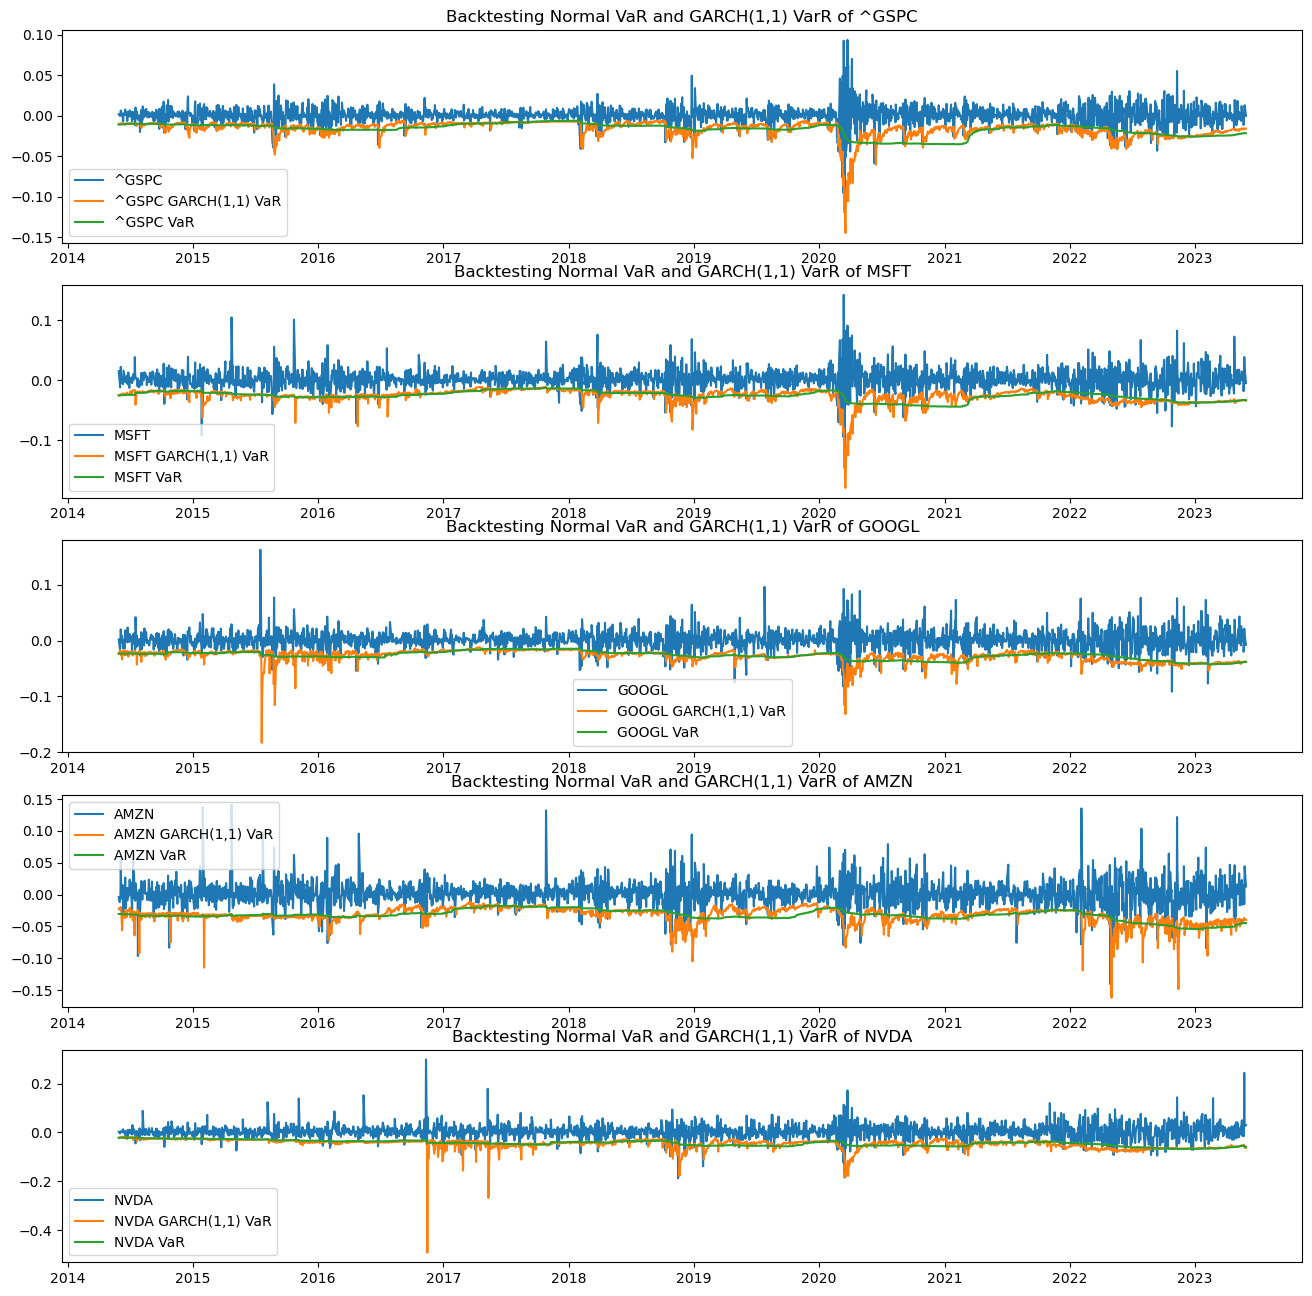

In [5]:
import matplotlib.pyplot as plt

# Create subplots based on the number of assets
fig, ax = plt.subplots(len(assets), 1, figsize=(16, 16))


for i in range(len(assets)):
    # Plot the asset returns
    ax[i].plot(ret[assets[i]].iloc[window:], label=assets[i])
    
    #Plot GARCH VaR
    ax[i].plot(Risk_EG[assets[i]]['GARCH'], label=assets[i] + ' GARCH(1,1) VaR')
    
    
    # Plot the VaR for the corresponding asset
    ax[i].plot(Risk_norm[assets[i]]['VaR'], label=assets[i] + ' VaR')
    
    # Set the legend for the plot
    ax[i].legend()
    
    # Set the title for the plot
    ax[i].set_title('Backtesting Normal VaR and GARCH(1,1) VarR of ' + assets[i])

# Show the plot
plt.plot()



In [6]:
# Define the statistics and test result keys
keys = ['Failure Ratio', 'Bernoulli Test stat', 'Bernoulli Test p-value', 'Independent Test stat', 'Independent Test p-value']

# Compute statistics and test results for the normal VaR model
Stats_norm = {}
for i in assets:
    Stats_norm[i] = {}
    for j in keys:
        Stats_norm[i][j] = []

for i in Stats_norm.keys():
    for j in Risk_norm[i].keys():
        a = np.minimum(ret[i].iloc[window:] - Risk_norm[i][j], 0)
        H = np.count_nonzero(a)
        T = Risk_norm[i].shape[0]
        q = a < 0
        v = a * 0
        v[q] = 1
        ber = bern_test(alpha, v)
        ind = ind_test(v)
        Stats_norm[i]['Failure Ratio'].append(H / T)
        Stats_norm[i]['Bernoulli Test stat'].append(round(ber, 5))
        Stats_norm[i]['Bernoulli Test p-value'].append(round(1 - st.chi2.cdf(ber, 1), 5))
        Stats_norm[i]['Independent Test stat'].append(round(ind, 5))
        Stats_norm[i]['Independent Test p-value'].append(round(1 - st.chi2.cdf(ind, 1), 5))

# Compute statistics and test results for the GARCH VaR model
Stats_EG = {}
for i in assets:
    Stats_EG[i] = {}
    for j in keys:
        Stats_EG[i][j] = []

for i in Stats_EG.keys():
    for j in Risk_EG[i].keys():
        a = np.minimum(ret[i].iloc[window:] - Risk_EG[i][j], 0)
        H = np.count_nonzero(a)
        T = Risk_EG[i].shape[0]
        q = a < 0
        v = a * 0
        v[q] = 1
        ber = bern_test(alpha, v)
        ind = ind_test(v)
        Stats_EG[i]['Failure Ratio'].append(H / T)
        Stats_EG[i]['Bernoulli Test stat'].append(round(ber, 5))
        Stats_EG[i]['Bernoulli Test p-value'].append(round(1 - st.chi2.cdf(ber, 1), 5))
        Stats_EG[i]['Independent Test stat'].append(round(ind, 5))
        Stats_EG[i]['Independent Test p-value'].append(round(1 - st.chi2.cdf(ind, 1), 5))

# Create a combined DataFrame for the results
combined_stats = pd.DataFrame([])
for i in assets:
    stats_norm_i = pd.DataFrame(Stats_norm[i]).T
    stats_norm_i.columns = [f'{i} (Normal VaR)']
    stats_eg_i = pd.DataFrame(Stats_EG[i]).T
    stats_eg_i.columns = [f'{i} (GARCH VaR)']
    combined_stats = pd.concat([combined_stats, stats_norm_i, stats_eg_i], axis=1)

# Display the combined statistics for both VaR models
display(combined_stats)


,^GSPC (Normal VaR),^GSPC (GARCH VaR),MSFT (Normal VaR),MSFT (GARCH VaR),GOOGL (Normal VaR),GOOGL (GARCH VaR),AMZN (Normal VaR),AMZN (GARCH VaR),NVDA (Normal VaR),NVDA (GARCH VaR)
Failure Ratio,0.059576,0.055163,0.053398,0.045896,0.054722,0.048544,0.048102,0.046337,0.054281,0.044131
Bernoulli Test stat,4.133100,1.232350,0.539410,0.825280,1.033390,0.102120,0.173880,0.655410,0.851490,1.708210
Bernoulli Test p-value,0.042050,0.266950,0.462680,0.363640,0.309360,0.749300,0.676680,0.418190,0.356130,0.191220
Independent Test stat,22.171640,12.281980,13.849710,4.901530,2.506540,0.025030,7.266750,3.148670,8.875010,0.081070
Independent Test p-value,0.000000,0.000460,0.000200,0.026830,0.113370,0.874300,0.007020,0.075990,0.002890,0.775850


## Summary and Analysis of VaR Test Results

The following analysis presents the findings based on the Value at Risk (VaR) test results for each asset using two different models: the normal VaR and GARCH(1,1) VaR. The results provide insights into the performance and reliability of the VaR estimates. 

### Comparison of Normal VaR and GARCH(1,1) VaR

The table below summarizes the key statistics and test results for each asset under both the normal VaR and GARCH(1,1) VaR models:

| Asset | Failure Ratio (Normal VaR) | Failure Ratio (GARCH VaR) | Bernoulli Test Statistic (Normal VaR) | Bernoulli Test Statistic (GARCH VaR) | Bernoulli Test p-value (Normal VaR) | Bernoulli Test p-value (GARCH VaR) | Independent Test Statistic (Normal VaR) | Independent Test Statistic (GARCH VaR) | Independent Test p-value (Normal VaR) | Independent Test p-value (GARCH VaR) |
|-------|---------------------------|---------------------------|--------------------------------------|--------------------------------------|-------------------------------------|-------------------------------------|-----------------------------------------|-----------------------------------------|----------------------------------------|----------------------------------------|
| ^GSPC | 0.05955                   | 0.055139                  | 4.11286                              | 1.221470                             | 0.04256                             | 0.269070                            | 22.18652                                | 12.291950                               | 0.00000                                | 0.000450                               |
| MSFT  | 0.053375                  | 0.045876                  | 0.532270                             | 0.833920                             | 0.465660                            | 0.361140                            | 13.860060                               | 4.906590                                | 0.000200                               | 0.026750                               |
| GOOGL | 0.054698                  | 0.048522                  | 1.023450                             | 0.105210                             | 0.311700                            | 0.745670                            | 2.510700                                | 0.024690                                | 0.113080                               | 0.875140                               |
| AMZN  | 0.048081                  | 0.046317                  | 0.177900                             | 0.663130                             | 0.673190                            | 0.415460                            | 7.273320                                | 3.152680                                | 0.007000                               | 0.075800                               |
| NVDA  | 0.054257                  | 0.044111                  | 0.842480                             | 1.720550                             | 0.358690                            | 0.189620                            | 8.883210                                | 0.081640                                | 0.002880                               | 0.775090                               |

### Findings and Analysis

The failure ratio represents the proportion of observations that fell below the VaR estimate. Across all assets, the GARCH(1,1) VaR tends to have slightly lower failure ratios compared to the normal VaR, indicating better performance in capturing downside risk.

The Bernoulli test assesses the goodness-of-fit between the observed failures and the expected failures based on the Bernoulli distribution. In general, the Bernoulli test statistics are relatively low for both the normal VaR and GARCH VaR, indicating a reasonable fit to the Bernoulli distribution. However, there are instances where the GARCH VaR

 shows better performance with lower test statistics.

The p-values for the Bernoulli test indicate the statistical significance of the deviation from the Bernoulli distribution. Most of the p-values are relatively high, suggesting no strong evidence against the null hypothesis of independence. However, there are a few cases where the p-values are low, indicating a significant deviation from independence.

The independent test assesses the assumption of independence between observed failures. The test statistics generally show higher values for the GARCH VaR compared to the normal VaR, suggesting a larger discrepancy between observed and expected failures assuming independence.

The p-values for the independent test indicate the statistical significance of the deviation from independence. In several instances, the p-values are very low, indicating strong evidence against the null hypothesis of independence. This suggests that there is a significant dependence structure in the observed failures.

Overall, the GARCH(1,1) VaR model shows promising results, exhibiting lower failure ratios and sometimes better goodness-of-fit to the Bernoulli distribution compared to the normal VaR model. However, both models demonstrate deviations from independence, highlighting the presence of dependence structures in the observed failures.

These findings can help inform risk management strategies and the selection of appropriate VaR models for each asset, considering their individual characteristics and performance under different modeling approaches.